# Mask R-CNN

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import glob
import random
import math
import numpy as np
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt

from MaskRCNN.config import Config
import MaskRCNN.utils as utils
import MaskRCNN.model as modellib
import MaskRCNN.visualize as visualize
from MaskRCNN.model import log

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("Download the COCO trained weights")
    # utils.download_trained_weights(COCO_MODEL_PATH)
    

In [4]:
train_path = os.path.join(ROOT_DIR, 'input/stage1_train')
val_path = os.path.join(ROOT_DIR,'input/stage1_val')
test_path = os.path.join(ROOT_DIR, 'input/stage1_test')   #path to test data file/folder

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [19]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1280

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
#     TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
#     VALIDATION_STEPS = 5
    
#     USE_MINI_MASK = True
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[320 320]
 [160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  1280
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING    

In [20]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

## Notebook Preferences

In [21]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [62]:
class NucleiDataset(utils.Dataset):
    """Loads the nuclei dataset.
    """
    
    def load_nuclei(self, path):
        '''
        Loads images from path/{id}/images/{id}.png
        '''
        self.add_class("nuclei", 1, "nuclei")
#         self.class_info = [{"source": "nuclei", "id": 0, "name": "nuclei"}]
        self.path = path
        
        img_info = [(id, '{0}/{1}/images/{1}.png'.format(path, id)) for id in os.listdir(path)]
        for id, path in img_info:
            self.add_image('nuclei', id, path)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        '''
        Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array. 
        Generate instance masks for shapes of the given image ID.
        '''
        info = self.image_info[image_id]
        
        img_paths = glob.glob('{0}/{1}/masks/*.png'.format(self.path, info['id']))
#         print(img_paths[0])
        

        masks = skimage.io.imread_collection(img_paths).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        plt.imshow(mask)
        mask = skimage.transform.resize(mask, output_shape=mask.shape+(len(img_paths),), mode='constant', preserve_range=True)
#         plt.imshow(mask)
        Y_data = np.array(mask, dtype=np.bool)
        
        
        
#         print(mask.shape)
        
        return Y_data, [0, 1]

In [63]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(train_path)
dataset_train.prepare()

(256, 320, 151)


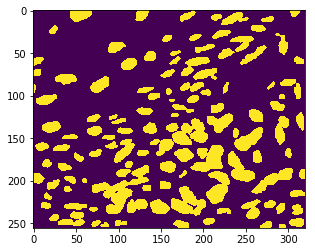

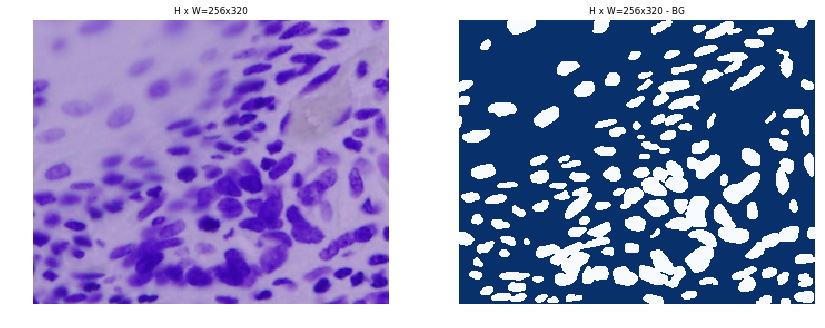

(256, 320, 26)


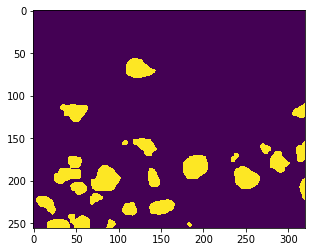

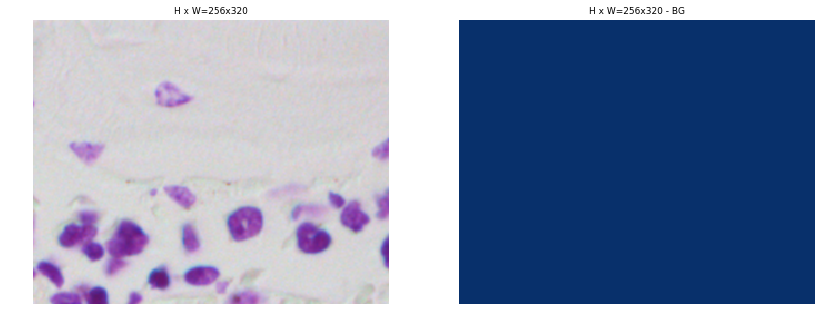

(256, 320, 63)


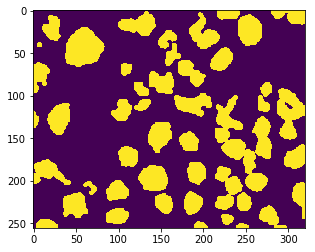

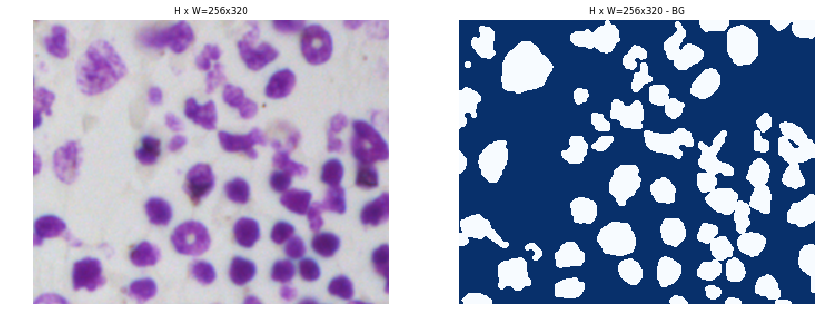

(360, 360, 20)


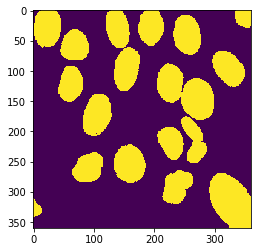

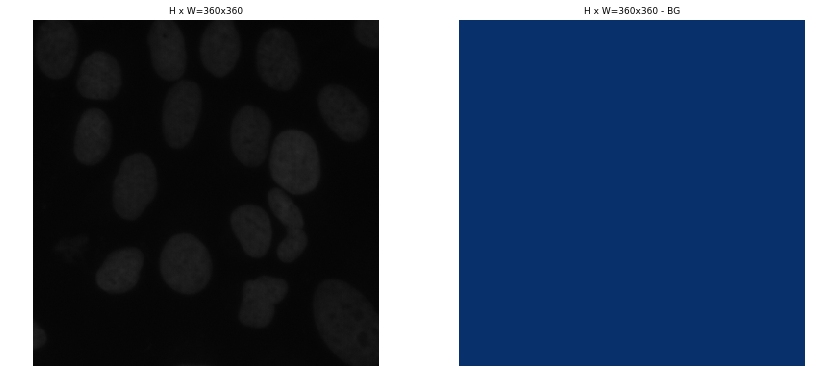

In [64]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    display_masks(image, mask, dataset_train.class_names)

In [65]:
# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(val_path)
dataset_val.prepare()

In [26]:
print(dataset_train.image_ids[2])
print(dataset_train.image_info[0]['id'])

2
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


In [27]:
print(dataset_val.image_ids[2])
print(dataset_val.image_info[0]['id'])

2
4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a


In [28]:
def display_masks(image, mask, class_names):
    """Display the given image and the masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    
#     to_display.append(mask)
    
    # Pull masks of instances belonging to the same class.
    m = mask
    m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
    to_display.append(m)
    titles.append("H x W={}x{} - {}".format(image.shape[0], image.shape[1], class_names[0]))
    visualize.display_images(to_display, titles=titles, cols=2, cmap="Blues_r")

(256, 256, 65)


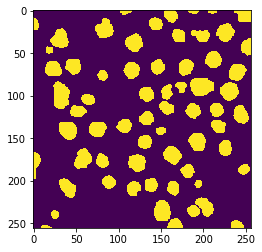

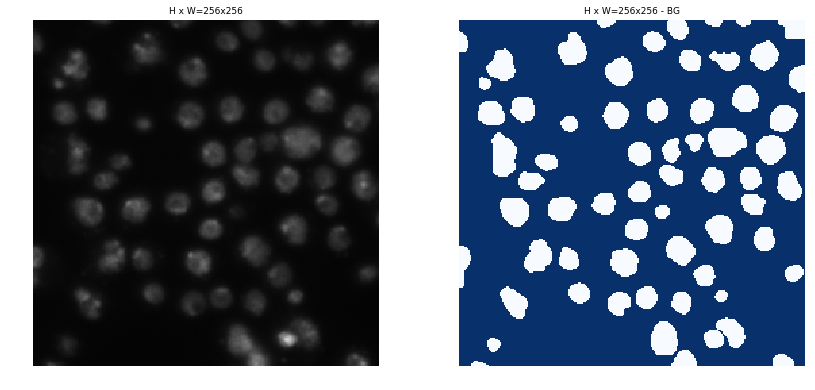

(360, 360, 23)


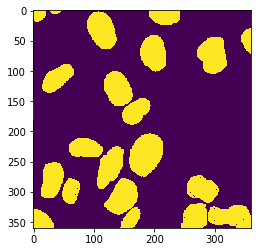

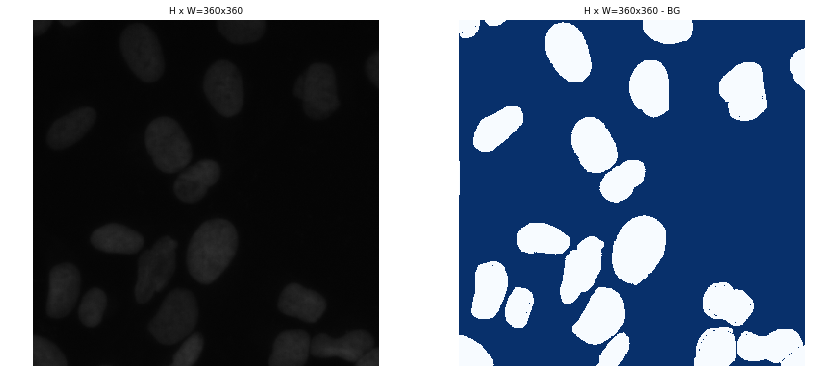

(256, 256, 32)


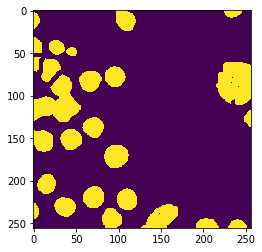

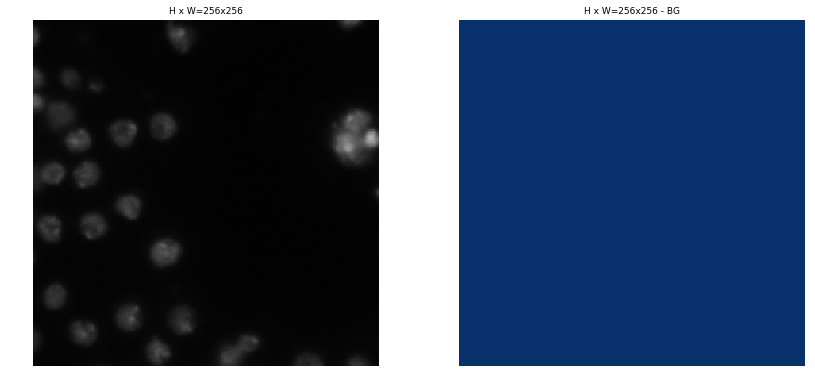

(256, 256, 15)


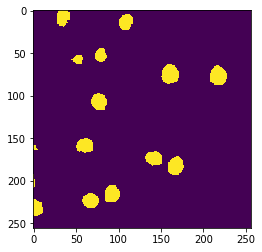

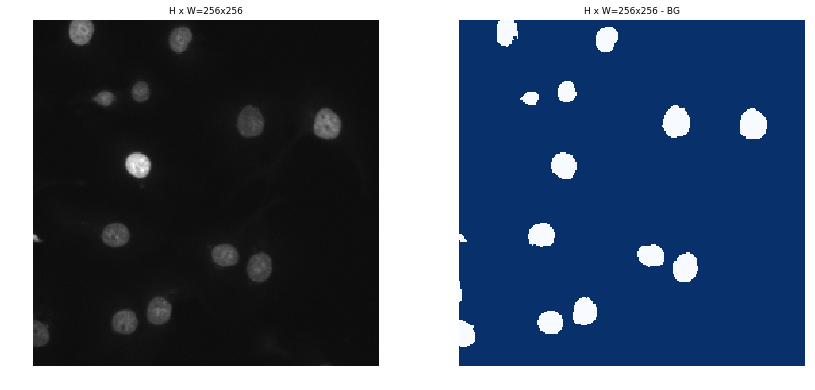

['BG', 'nuclei']


In [29]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
#     print(dataset_train.image_info[image_id]['path'])
    print(mask.shape)
#     print(mask.shape[2])
#     if (mask.shape[2] == 0):
#         print(mask)
#         print(dataset_train.image_info[image_id]['path'])
    display_masks(image, mask, dataset_train.class_names)
print(dataset_train.class_names)

## Create Model

In [30]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [31]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training


Starting at epoch 0. LR=0.001

Checkpoint Path: /src/workspace/data-science-bowl-2018/logs/nuclei20180306T1549/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

ERROR:root:Error processing image {'id': '3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe', 'source': 'nuclei', 'path': '/src/workspace/data-science-bowl-2018/input/stage1_train/3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe/images/3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe.png'}
Traceback (most recent call last):
  File "/src/workspace/data-science-bowl-2018/MaskRCNN/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/src/workspace/data-science-bowl-2018/MaskRCNN/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/src/workspace/data-science-bowl-2018/MaskRCNN/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero
ERROR:root:Error processing image {'id': '5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14', 'source': 'nuclei

Exception: Invalid bounding box with area of zero

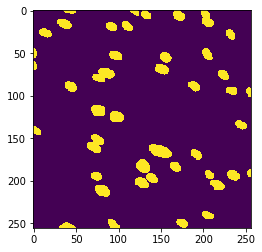

In [33]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')